<a href="https://colab.research.google.com/github/vitorpaziam/Chatbot-Vestibular-Unicamp/blob/main/docs/model_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Chatbot Admissão Unicamp 2024 - Model Validation**

## Generating data from ChatGPT

The initial approach was to automate the test set creation process by using the ChatGPT API through a [script](https://github.com/vitorpaziam/Chatbot-Vestibular-Unicamp/blob/main/generate_testset.py) to perform queries, creating a CSV file that paired each question with its expected answer based on the content of each *chunk* of the text from the [Resolução GR-031/2023](https://www.pg.unicamp.br/norma/31594/0).
However, the *script* was unable to generate a sufficient amount of data due to extended execution times leading to timeouts. Consequently, the ChatGPT's interface was employed for data generation, enabling the *manual creation* of the test set through message-based interactions. General structure of the messages and responses that formed the [test set](https://github.com/vitorpaziam/Chatbot-Vestibular-Unicamp/blob/main/dataset/testset_direct.csv) (In Portuguese):

- Message:
> Para as próximas solicitações, se comporte como um assistente que deve fazer e responder perguntas sobre o processo de Admissão na Unicamp 2024. Escreva em formato tabular uma tabela com as colunas 'generated_question' e 'generated_answer' e em que cada linha coloque uma pergunta direta e objetiva e a resposta dessa pergunta em que as informações estão contidas e se baseiam no conteúdo do trecho do Edital da Unicamp 2024: {trecho}

- ChatGPT's answer:

<center>

| generated_question |  generated_answer  |
| :----------------: | :----------------: |
| {pergunta_gerada1} | {resposta_gerada1} |
| {pergunta_gerada2} | {resposta_gerada2} |
| {pergunta_gerada3} | {resposta_gerada3} |
| ... | ... |

</center>




## Testing the model

The methodology employed to evaluate the model consisted of iterating through the *test set* file, inputting the `generated_question` into the model, and subsequently comparing the model's output with the expected response in `generated_answer`. This comparison was achieved utilizing the *TF-IDF vectorizer* and *cosine similarity* (ChatGPT's recommendation). Each comparison generated a score within the range of `[0..1000]`, where higher values denoted a greater degree of similarity between the responses.

<center>

<img src="https://miro.medium.com/v2/resize:fit:824/1*GK56xmDIWtNQAD_jnBIt2g.png" alt="Cosine Similarity Schema" width="600"/>

</center>

From the [model testing code](https://github.com/vitorpaziam/Chatbot-Vestibular-Unicamp/blob/main/model_testing.py), two new columns, `model_answer` and `model_answer_score`, were created to store these results for each row. Subsequently, a new file was generated, containing the [test outcomes](https://github.com/vitorpaziam/Chatbot-Vestibular-Unicamp/blob/main/dataset/testset_direct_with_model_answers.csv).


## Analysis of the model's test data

Loading the CSV file data with the test results into a Pandas `DataFrame`.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

url = "https://raw.githubusercontent.com/vitorpaziam/Chatbot-Vestibular-Unicamp/main/dataset/testset_direct_with_model_answers.csv"
data = pd.read_csv(url)

data.head()

,generated_question,generated_answer,model_answer,model_answer_score
0,Qual é o objetivo do Vestibular Unicamp 2024?,O VU 2024 tem por objetivos: I. Classificar e ...,"O objetivo do Vestibular Unicamp 2024, de acor...",964
1,Quais são os critérios de avaliação no Vestibu...,"Para alcançar os objetivos estabelecidos, o VU...",Os critérios de avaliação do Vestibular Unicam...,912
2,Quem pode se inscrever no Vestibular Unicamp 2...,Poderá se inscrever no VU 2024 o(a) candidato(...,Podem se inscrever no Vestibular Unicamp 2024 ...,682
3,Quantas vagas são oferecidas pelo Vestibular U...,São oferecidas 2537 vagas pelo Vestibular Unic...,O Vestibular Unicamp 2024 oferece 2537 vagas.,945
4,Onde posso encontrar informações sobre o Vesti...,"O Manual do Ingresso, contendo todas as inform...",As informações sobre as vagas oferecidas pelo ...,876


Setting the desired similarity threshold and calculating the model's accuracy based on the `model_answer_score` values.

In [ ]:
threshold = 650

accurate_predictions = data[data['model_answer_score'] >= threshold]
accuracy = len(accurate_predictions) / len(data) * 100

print(f"Model accuracy: {accuracy:.2f}%")

Model accuracy: 83.53%


Visualizing the distribution of similarity scores.

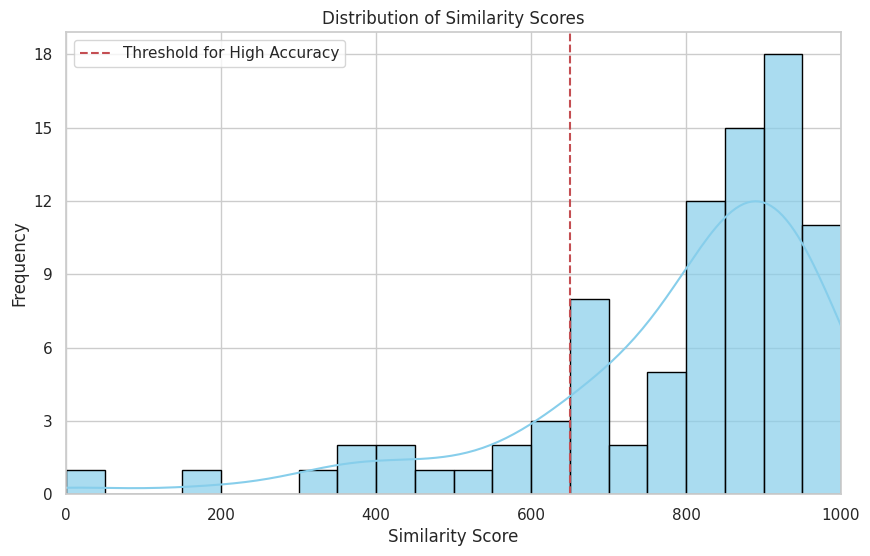

In [ ]:
plt.figure(figsize = (10, 6))
sns.histplot(data['model_answer_score'], kde = True, bins = 20, color = 'skyblue', edgecolor = 'black', alpha = 0.7)
sns.set(style = 'whitegrid')

# Setting up interval divisions
plt.xlim(0, 1000)
plt.yticks(range(0, 20, 3))

# Add title and labels
plt.title('Distribution of Similarity Scores')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')

# Add threshold line
plt.axvline(x = threshold, color = 'r', linestyle = '--', label = 'Threshold for High Accuracy')
plt.legend()

plt.show()

Identifying and displaying cases with low `model_answer_score`, in order to understand the weaknesses and vulnerabilities of the model.

In [ ]:
not_accurate_predictions = data[data['model_answer_score'] < threshold]
not_accurate_predictions = not_accurate_predictions.sort_values(by = 'model_answer_score', ascending = False)

# Showing the set of not accurated predictions
if not not_accurate_predictions.empty:
  for index, row in not_accurate_predictions.iterrows():
    print(f"{index} -> Question: {row['generated_question']}")
    print(f"{index} -> Expected answer: {row['generated_answer']}")
    print(f"{index} -> Model answer: {row['model_answer']}")
    print(f"{index} -> Model score: {row['model_answer_score']}")
    print() # Break line
else:
  print("No prediction was considered not accurated!")

Through the conducted tests, a potential vulnerability of the model was identified regarding questions about tabular content, as evidenced by the following results:

- **data - Index 74**

**-> Question:** Quais são os cursos oferecidos na área de Ciências Humanas/Artes?\
**-> Expected answer:** Administração (Noturno), Administração Pública (Noturno), Arquitetura e Urbanismo (Noturno), Artes Cênicas (Integral), Artes Visuais (Integral), Comunicação Social - Midialogia (Integral), Ciências Econômicas (Integral), Ciências Econômicas (Noturno), Ciências Sociais (Integral), Ciências Sociais (Noturno), Dança (Integral), Estudos Literários (Integral), Filosofia (Integral), Geografia (Integral), Geografia (Noturno), História (Integral), Letras - Licenciatura (Integral), Letras - Licenciatura (Noturno), Linguística (Integral), Música (Integral), Pedagogia - Licenciatura (Integral), Pedagogia - Licenciatura (Noturno).\
**-> Model answer:** Os cursos oferecidos na área de Ciências Humanas/Artes são: - Artes Visuais- Música Erudita- Música Popular\
**-> Model score:** 190

- **data - Index 75**

**-> Question:** Quais são os cursos oferecidos na área de Ciências Biológicas/Saúde?\
**-> Expected answer:** Ciências Biológicas (Integral), Ciências Biológicas - Licenciatura (Noturno), Ciências do Esporte (Integral), Educação Física (Integral), Educação Física (Noturno), Enfermagem (Integral), Farmácia (Integral), Fonoaudiologia (Integral), Medicina (Integral), Nutrição (Integral), Odontologia (Integral).\
**-> Model answer:** Os cursos oferecidos na área de Ciências Biológicas/Saúde são Biologia, Medicina, Odontologia, Enfermagem, Farmácia, Fisioterapia, Nutrição, Biomedicina, Veterinária, entre outros.\
**-> Model score:** 352

- **data - Index 76**

**-> Question:** Quais são os cursos oferecidos na área de Ciências Exatas/Tecnológicas?\
**-> Expected answer:** Ciência da Computação (Noturno), Engenharia Física/Física/Física Médica e Biomédica/Matemática/Matemática Aplicada e Computacional (Integral), Engenharia Agrícola (Integral), Engenharia Ambiental (Noturno), Engenharia Civil (Integral), Engenharia de Alimentos (Integral), Engenharia de Alimentos (Noturno), Engenharia de Computação (Integral), Engenharia de Controle e Automação (Noturno), Engenharia de Manufatura (Integral), Engenharia de Produção (Integral), Engenharia de Telecomunicações (Integral), Engenharia de Transportes (Noturno), Engenharia Elétrica (Integral), Engenharia Elétrica (Noturno), Engenharia Mecânica (Integral), Engenharia Química (Integral), Engenharia Química (Noturno), Estatística (Integral), Física - Licenciatura (Noturno), Geologia (Integral), Licenciatura Integrada Química/Física (Noturno), Matemática - Licenciatura (Noturno), Química (Integral), Química Tecnológica (Noturno), Sistemas de Informação (Integral), Tecnologia em Análise e Desenvolvimento de Sistemas (Noturno), Tecnologia em Saneamento Ambiental (Noturno).\
**-> Model answer:** Os cursos oferecidos na área de Ciências Exatas/Tecnológicas são Matemática, Física, Física Médica, Biomédica e Química.\
**-> Model score:** 333

This model's inefficiency might be linked to the file format (PDF) used to create the *embeddings*, as extracting content from tables in that format can lead to *distorted data*.

## Conclusions

The model exhibited a satisfactory accuracy of __*83,53%*__. However, this value is subject to some *inaccuracy* due to factors such as:

**1. Data Used for Model Testing**

The choice of questions for model testing significantly impacts its performance. In this test, the ChatGPT was prompted to generate direct and objective questions based on specific excerpts from the document. Using a test set that includes interpretative or conversational questions, i.e. questions related to previous ones, may result in varying accuracy outcomes. Furthermore, it is crucial to consider potential errors in the responses generated by ChatGPT, which will be used as expected answers for the model during the validation phase.

**2. Model Validation Method**

The method *TF-IDF (Term Frequency-Inverse Document Frequency)* used for vectorization assigns weights to words based on their occurrence in a document compared to a larger corpus. *Cosine similarity* measures the similarity between vectors, aiding in the evaluation of semantic similarity. However, due to the complexities of language, even with shared words, nuanced differences in context and meaning can occasionally lead to inconsistencies in results, particularly when comparing the expected and model answers. Some examples of inaccuracies associated with this method of validating model are:

- High similarity score, as the `Model answer` contains similar words to the `Expected answer`. However, it implies divergent responses:

>**data - Index 32**\
**-> Question:** Quais são os índices de conteúdos programáticos gerais para a prova de Língua Portuguesa?\
**-> Expected answer:** Os índices de conteúdos programáticos gerais para a prova de Língua Portuguesa incluem o texto e seu funcionamento, processos de significação, funcionamento social da língua, sintaxe da língua portuguesa, morfologia da língua portuguesa e elementos de fonologia da língua portuguesa.\
**-> Model answer:** Os índices de conteúdos programáticos gerais para a prova de Língua Portuguesa não são mencionados no texto fornecido.\
**-> Model score:** 689

- Low similarity score with suitable and correct `Model answer` for `Question`:

>**data - Index 28**\
**-> Question:** Quantas questões objetivas compõem a prova da primeira fase?\
**-> Expected answer:** A prova da primeira fase é composta por 72 questões objetivas distribuídas da seguinte forma: 12 questões de Matemática, 12 questões de Língua Portuguesa e Literaturas de Língua Portuguesa, 7 questões de Inglês, 21 questões de Ciências da Natureza (Biologia, Química e Física) e 20 questões de Ciências Humanas (História, Geografia, Filosofia e Sociologia).\
**-> Model answer:** A prova da primeira fase é composta por 72 questões objetivas.\
**-> Model score:** 485

**3. Threshold Definition**

The selection of the threshold value has a direct impact on the model's accuracy. The aim in defining this value is to find a threshold that represents a subtle division between responses with good and poor accuracies. In this study, setting `threshold = 650` proved to be appropriate, as demonstrated by the examples that are close to the threshold:

- Model generates a correct but incomplete response, consequently, it isn't considered as an `accurate_prediction`:

> **data - Index 49**\
**-> Question:** Qual o conteúdo do índice programático geral de Ciências Biológicas da prova da Unicamp 2024?\
**-> Expected answer:** Os conteúdos programáticos gerais abrangem bases moleculares e celulares da vida, hereditariedade, origem e evolução da vida, o ambiente e a vida, biodiversidade, e saúde humana.\
**-> Model answer:** O conteúdo programático geral da prova de Ciências Biológicas da Unicamp 2024 inclui os seguintes tópicos:
\- Bases moleculares e celulares da vida, abrangendo componentes bioquímicos da célula, estrutura celular em procariotos e eucariotos, organelas em células vegetais e animais, origem evolutiva das organelas, células-tronco, ciclo celular e divisão celular mitótica e meiótica.\- Hereditariedade, envolvendo hereditariedade e material genético (DNA e RNA), código genético e síntese de proteínas, leis de segregação mendeliana e padrões de herança.
Esses são alguns dos tópicos que podem ser abordados na prova de Ciências Biológicas da Unicamp 2024. É importante ressaltar que essa lista não é exaustiva e outros temas relacionados à Biologia também podem ser incluídos.\
**-> Model score:** 639

- The model provides a response that includes the main idea of the question but without the detail presented in the expected response. Therefore, it is considered an `accurate_prediction`:

> **data - Index 2**\
**-> Question:** Quem pode se inscrever no Vestibular Unicamp 2024?\
**-> Expected answer:** Poderá se inscrever no VU 2024 o(a) candidato(a) que satisfizer a uma das seguintes condições: I. Ser portador(a) de certificado de conclusão de Ensino Médio ou equivalente. II. Estar cursando o Ensino Médio ou equivalente. III. Ser portador(a) de diploma de curso superior.\
**-> Model answer:** Podem se inscrever no Vestibular Unicamp 2024 os candidatos que tenham concluído curso de graduação ou pós-graduação em Instituições de Ensino Superior públicas brasileiras (municipais, estaduais ou federais).\
**-> Model score:** 682